Libraries & Parameters

In [1]:
!pip install -q awswrangler

import awswrangler as wr
import pandas as pd

import boto3
import pytz

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from sagemaker import get_execution_role

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# Get Sagemaker Role
role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210503T205912 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::506926764659:role/service-role/AmazonSageMaker-ExecutionRole-20210503T205912


# 1.) Download Data

## S3 parameters

In [3]:
# Flight data from 2007 and 2011 via Sagemaker Data Wrangler
bucket = 'sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default'
filename = 'part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'
path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from 2011_01 
# bucket = 'from-public-data/carrier-perf/transformed/airOT2011'
# filename = 'airOT201101.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)

path_to_file

's3://sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default/part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'

## Download data from S3

In [4]:
df = wr.s3.read_csv([path_to_file])
df

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_TIME,...,ARR_DELAY,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight,DEP_DELAY_no_outlier
0,2007,1,1,1,9E,11278,DCA,11986,GRR,2044.0,...,70.0,95.0,524.0,0.0,0.0,26.0,0.0,44.0,late,44
1,2007,1,1,1,9E,13487,MSP,11003,CID,1939.0,...,75.0,39.0,221.0,7.0,0.0,68.0,0.0,0.0,late,7
2,2007,1,1,1,9E,13487,MSP,11637,FAR,913.0,...,-19.0,39.0,223.0,NaN,NaN,NaN,NaN,NaN,late,-2
3,2007,1,1,1,9E,13487,MSP,10469,AZO,2122.0,...,53.0,55.0,426.0,53.0,0.0,0.0,0.0,0.0,late,57
4,2007,1,1,1,9E,13487,MSP,11298,DFW,1410.0,...,-7.0,123.0,852.0,NaN,NaN,NaN,NaN,NaN,late,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294644,2007,12,31,1,YV,16218,YUM,14107,PHX,750.0,...,-12.0,38.0,160.0,NaN,NaN,NaN,NaN,NaN,late,-10
7294645,2007,12,31,1,YV,16218,YUM,14107,PHX,1220.0,...,-12.0,33.0,160.0,NaN,NaN,NaN,NaN,NaN,late,-14
7294646,2007,12,31,1,YV,16218,YUM,14107,PHX,1600.0,...,-2.0,33.0,160.0,NaN,NaN,NaN,NaN,NaN,late,-5
7294647,2007,12,31,1,YV,16218,YUM,14107,PHX,900.0,...,-10.0,31.0,160.0,NaN,NaN,NaN,NaN,NaN,late,-30


# 2.) Features Engineering

### Add new feature as target variable `is_late`

In [5]:
late_flight = []

for i in df['DEP_DELAY']:
    if i > 0 : late_flight.append('late')
    else: late_flight.append('not_late')
        
df['late_flight'] = late_flight
# df

### Select needed features

In [6]:
# REF. https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy

df_toTrain = df[[
    'YEAR',
    'MONTH',
    'DAY_OF_MONTH',
    'DAY_OF_WEEK',
    'UNIQUE_CARRIER',
    'ORIGIN_AIRPORT_ID',
    'ORIGIN',
    'DEST_AIRPORT_ID',
    'DEST',
    'DEP_TIME',
    'DEP_DELAY',
    'ARR_TIME',
    'ARR_DELAY',
    'AIR_TIME',
    'ACTUAL_ELAPSED_TIME',
    'DISTANCE',
    'CARRIER_DELAY',
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'late_flight'
]].copy()

df_toTrain

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_TIME,...,ARR_DELAY,AIR_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight
0,2007,1,1,1,9E,11278,DCA,11986,GRR,2044.0,...,70.0,95.0,138.0,524.0,0.0,0.0,26.0,0.0,44.0,late
1,2007,1,1,1,9E,13487,MSP,11003,CID,1939.0,...,75.0,39.0,132.0,221.0,7.0,0.0,68.0,0.0,0.0,late
2,2007,1,1,1,9E,13487,MSP,11637,FAR,913.0,...,-19.0,39.0,56.0,223.0,NaN,NaN,NaN,NaN,NaN,not_late
3,2007,1,1,1,9E,13487,MSP,10469,AZO,2122.0,...,53.0,55.0,88.0,426.0,53.0,0.0,0.0,0.0,0.0,late
4,2007,1,1,1,9E,13487,MSP,11298,DFW,1410.0,...,-7.0,123.0,138.0,852.0,NaN,NaN,NaN,NaN,NaN,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7294644,2007,12,31,1,YV,16218,YUM,14107,PHX,750.0,...,-12.0,38.0,65.0,160.0,NaN,NaN,NaN,NaN,NaN,not_late
7294645,2007,12,31,1,YV,16218,YUM,14107,PHX,1220.0,...,-12.0,33.0,54.0,160.0,NaN,NaN,NaN,NaN,NaN,not_late
7294646,2007,12,31,1,YV,16218,YUM,14107,PHX,1600.0,...,-2.0,33.0,58.0,160.0,NaN,NaN,NaN,NaN,NaN,not_late
7294647,2007,12,31,1,YV,16218,YUM,14107,PHX,900.0,...,-10.0,31.0,74.0,160.0,NaN,NaN,NaN,NaN,NaN,not_late


# 3.) Data Analysis

In [7]:
# List airlines
df_toTrain['UNIQUE_CARRIER'].unique().tolist()      ## 20-airlines

# List Dep. Airports
df_toTrain['ORIGIN'].unique().shape                 ## 304 orgins
# List Arr. Airports
df_toTrain['DEST'].unique().shape                   ## 310 orgins

(310,)

## a. Correlations Heatmap
of independent variables

Text(0.5, 1, 'Correlation Heatmap')

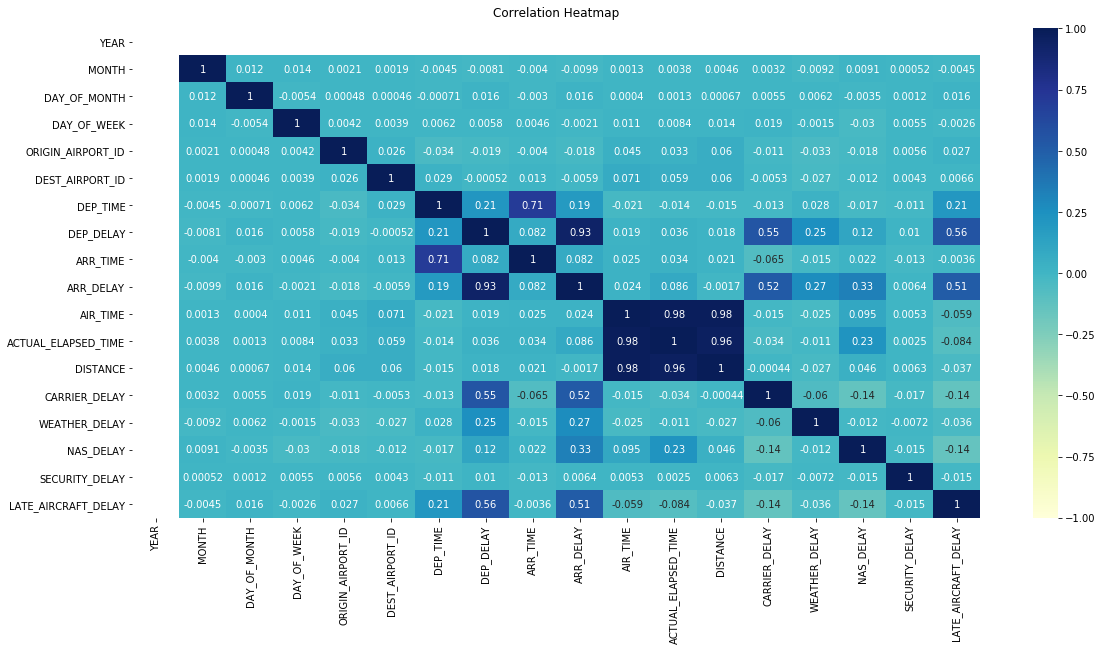

In [8]:
# ref. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

# increase figure size
plt.figure(figsize=(19, 9))

heatmap = sns.heatmap(df_toTrain.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")

# define title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

**Highly correlated**
  - `AIR_TIME` :: `ACTUAL_ELAPSED_TIME` :: `DISTANCE` --> Keep only `ACTUAL_ELAPSED_TIME`

# 4.) Train Model

## Download PyCaret libraries

In [9]:
# Download PyCaret
!pip install pycaret --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: pandas-profiling 2.12.0 has requirement matplotlib>=3.2.0, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: pandas-profiling 2.12.0 has requirement seaborn>=0.10.1, but you'll have seaborn 0.10.0 which is incompatible.


## Get the Data

In [10]:
data = df_toTrain.sample(frac=0.01, random_state=123)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (72946, 22)
Unseen Data For Predictions: (7221703, 23)


## Setting Up Environment in PyCaret

In [12]:
from pycaret.classification import *
exp = setup(data = data, 
            numeric_features = ['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK'],
            ignore_features = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'YEAR', 'DEP_DELAY', 'DEP_DELAY', 'AIR_TIME', 'ACTUAL_ELAPSED_TIME'],
            target = 'late_flight',
            fix_imbalance = True,
            normalize = True,
            transformation = True,
            ignore_low_variance = True,
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.95,
            fix_imbalance = True,
            use_gpu = True,
            fold = 2
           )

,Description,Value
0,session_id,8532
1,Target,late_flight
2,Target Type,Binary
3,Label Encoded,"late: 0, not_late: 1"
4,Original Data,"(72946, 22)"
5,Missing Values,True
6,Numeric Features,12
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


## Comparing all models

In [13]:
# ref. 
#   -- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=compare_models#pycaret.classification.compare_models
#   -- https://machinelearningmastery.com/k-fold-cross-validation/

best_model = compare_models(cross_validation=False)
# best_model = compare_modelfold=old=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8138,0.8949,0.8846,0.8080,0.8446,0.6136,0.6175,118.8200
rf,Random Forest Classifier,0.8116,0.8868,0.8864,0.8043,0.8433,0.6086,0.6131,125.8300
gbc,Gradient Boosting Classifier,0.8045,0.8888,0.8541,0.8134,0.8332,0.5973,0.5983,159.5900
ada,Ada Boost Classifier,0.7992,0.8816,0.8389,0.8153,0.8269,0.5878,0.5882,125.1100
et,Extra Trees Classifier,0.7959,0.8697,0.8748,0.7907,0.8306,0.5756,0.5803,133.9800
lr,Logistic Regression,0.7948,0.8785,0.8106,0.8272,0.8188,0.5824,0.5826,123.2800
svm,SVM - Linear Kernel,0.7942,0.7876,0.8335,0.8117,0.8225,0.5778,0.5781,117.2000
ridge,Ridge Classifier,0.7932,0.7863,0.8342,0.8099,0.8219,0.5755,0.5758,115.8900
lda,Linear Discriminant Analysis,0.7932,0.8750,0.8342,0.8099,0.8219,0.5756,0.5759,124.0000
dt,Decision Tree Classifier,0.7479,0.7435,0.7744,0.7826,0.7785,0.4861,0.4862,118.0400


# 5.) Create Model(s)

## a. Light Gradient Boosting Machine

In [15]:
dt = create_model('lightgbm', cross_validation=False)

# trained model object is stored as `lightgbm`
print(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8138,0.8949,0.8846,0.808,0.8446,0.6136,0.6175


NameError: name 'lightgbm' is not defined

## b. Random Forest Classifier

In [16]:
rf = create_model('rf', cross_validation=False)

# trained model object is stored as `rf`
print(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8116,0.8868,0.8864,0.8043,0.8433,0.6086,0.6131


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=8532, verbose=0,
                       warm_start=False)


# 6.) Tune Model(s)

## a. Light Gradient Boosting Machine

In [17]:
tuned_lightgbm = tune_model(lightgbm, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_lightgbm`
print(tuned_lightgbm)

NameError: name 'lightgbm' is not defined

## b. Random Forest Classifier

In [18]:
tuned_rf = tune_model(rf, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_rf`
print(tuned_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7896,0.8621,0.8361,0.8028,0.8191,0.5679,0.5686
1,0.7895,0.8624,0.8263,0.8085,0.8173,0.5691,0.5693
Mean,0.7895,0.8622,0.8312,0.8056,0.8182,0.5685,0.5690
SD,0.0000,0.0001,0.0049,0.0029,0.0009,0.0006,0.0004


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=8532, verbose=0,
                       warm_start=False)


# 7.) Models Performance

## a. Decision Tree Classifier

### i. Features Importance

In [ ]:
plot_model(tuned_dt, plot='feature')

### ii. Confusion Matrix

In [ ]:
plot_model(tuned_dt, plot = 'confusion_matrix')

## b. Random Forest Classifer

### i. Features Importance

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


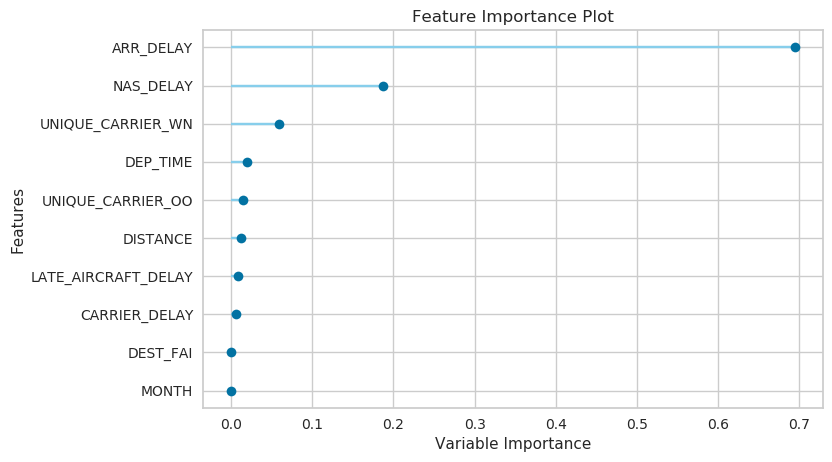

In [19]:
plot_model(tuned_rf, plot='feature')

### ii. Confusion Matrix

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


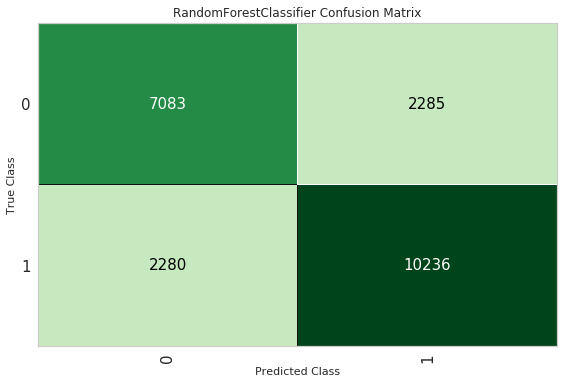

In [20]:
plot_model(tuned_rf, plot = 'confusion_matrix')

# 8.) Predict of Test Data Sample

## a. Decision Tree Classifier

In [ ]:
predict_model(tuned_dt);

## b. Random Forest Classifer

In [21]:
predict_model(tuned_rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7914,0.8663,0.8178,0.8175,0.8177,0.5740,0.5740


# 9.) Deploy Model (finalized)

## a. Decision Tree Classifier

In [ ]:
final_dt = finalize_model(tuned_dt)

#Final Decision Tree Classifier model parameters for deployment
print(final_dt)

## b. Random Forest Classifer

In [22]:
final_rf = finalize_model(tuned_rf)

#Final Randdom Forest model parameters for deployment
print(final_rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=8532, verbose=0,
                       warm_start=False)


# 10.) Predict on Unseen Data

In [ ]:
unseen_predictions = predict_model(final_rf, data=data_unseen)

In [1]:
from pycaret.utils import check_metric

check_metric(unseen_predictions['default'], unseen_predictions['Label'], metric = 'Accuracy')

NameError: name 'unseen_predictions' is not defined